<a href="https://colab.research.google.com/github/esp1745/Great-Farmer-Project/blob/main/marketingCampaigns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

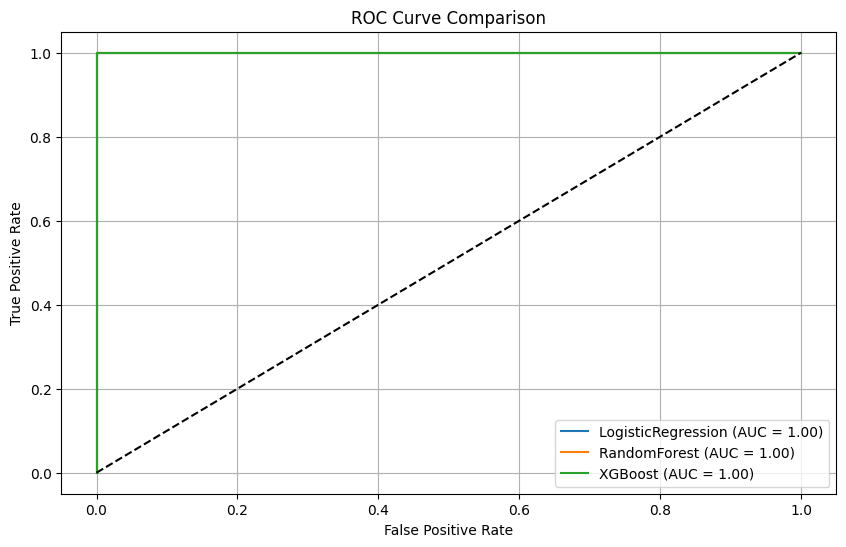

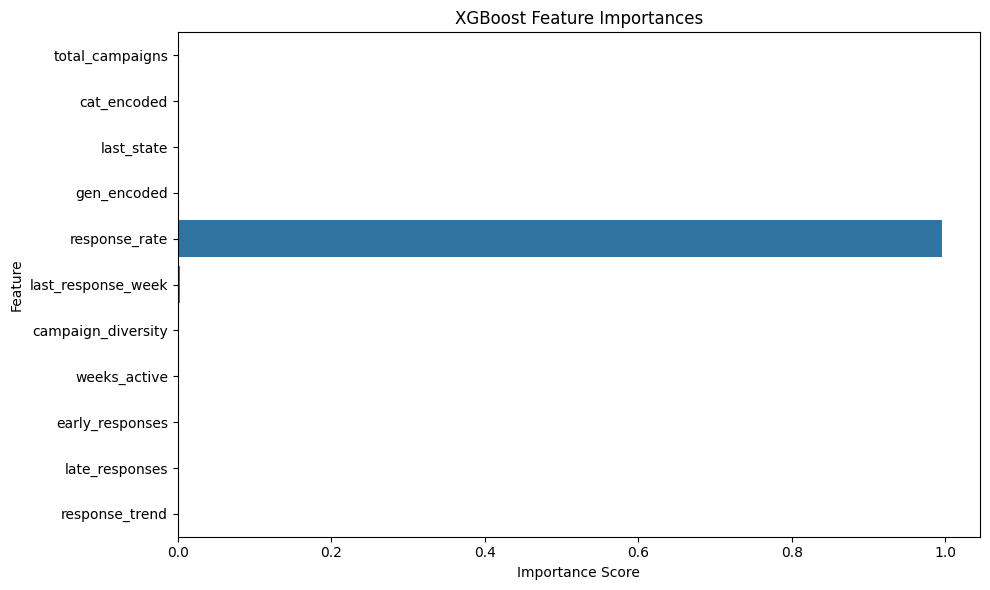

📌 Project Answers:
1. Which Subscribers to Email (First 10 Shown):
[13184, 13183, 13182, 13179, 13178, 13177, 13176, 13174, 13173, 13170]

2. Campaign Distribution for Week 27:
{1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250, 7: 250, 8: 250, 9: 250, 10: 250}

3. Expected Response Rate: 99.99%

📊 Model Performance Summary:
             Model ROC AUC Score
LogisticRegression        1.0000
      RandomForest        1.0000
           XGBoost        1.0000

📊 Evaluation on Simulated Week 27 (actual Week 26):
              precision    recall  f1-score   support

           0       0.95      0.13      0.22      4287
           1       0.60      0.99      0.75      5713

    accuracy                           0.62     10000
   macro avg       0.78      0.56      0.49     10000
weighted avg       0.75      0.62      0.52     10000

ROC AUC Score: 0.6464


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

# -------------------------------
# 1. Load and clean the data
# -------------------------------
df = pd.read_excel("hist.xlsx")
df.columns = ['week', 'subscriber_id', 'user_category', 'state_id', 'gender', 'campaign_id', 'response']
df.dropna(inplace=True)

# -------------------------------
# 2. Feature Engineering
# -------------------------------
agg = df.groupby('subscriber_id').agg(
    total_campaigns=('campaign_id', 'count'),
    total_responses=('response', 'sum'),
    last_category=('user_category', 'last'),
    last_state=('state_id', 'last'),
    last_gender=('gender', 'last'),
    first_week=('week', 'min'),
    last_week=('week', 'max')
).reset_index()

le_cat = LabelEncoder()
le_gen = LabelEncoder()
agg['cat_encoded'] = le_cat.fit_transform(agg['last_category'])
agg['gen_encoded'] = le_gen.fit_transform(agg['last_gender'])

agg['response_rate'] = agg['total_responses'] / agg['total_campaigns']
agg['responded'] = (agg['total_responses'] > 0).astype(int)

last_response_week = df[df['response'] == 1].groupby('subscriber_id')['week'].max().reset_index()
last_response_week.columns = ['subscriber_id', 'last_response_week']
agg = agg.merge(last_response_week, on='subscriber_id', how='left')
agg['last_response_week'] = agg['last_response_week'].fillna(0)

campaign_div = df.groupby('subscriber_id')['campaign_id'].nunique().reset_index()
campaign_div.columns = ['subscriber_id', 'campaign_diversity']
agg = agg.merge(campaign_div, on='subscriber_id', how='left')

agg['weeks_active'] = agg['last_week'] - agg['first_week'] + 1

early = df[df['week'] <= 13].groupby('subscriber_id')['response'].sum().reset_index(name='early_responses')
late = df[df['week'] > 13].groupby('subscriber_id')['response'].sum().reset_index(name='late_responses')
agg = agg.merge(early, on='subscriber_id', how='left').merge(late, on='subscriber_id', how='left')
agg[['early_responses', 'late_responses']] = agg[['early_responses', 'late_responses']].fillna(0)
agg['response_trend'] = agg['late_responses'] - agg['early_responses']

# -------------------------------
# 3. Model Training
# -------------------------------
features = [
    'total_campaigns', 'cat_encoded', 'last_state', 'gen_encoded',
    'response_rate', 'last_response_week', 'campaign_diversity',
    'weeks_active', 'early_responses', 'late_responses', 'response_trend'
]
X = agg[features]
y = agg['responded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    results[name] = {
        'model': model,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'proba': y_proba
    }

# -------------------------------
# 4. Plot ROC Curves
# -------------------------------
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f"{name} (AUC = {result['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# -------------------------------
# 5. Plot Feature Importances for XGBoost
# -------------------------------
xgb_model = results['XGBoost']['model']
importances = xgb_model.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# -------------------------------
# 6. Week 27 Selection Strategy
# -------------------------------
agg['predicted_proba'] = xgb_model.predict_proba(X)[:, 1]
agg_sorted = agg.sort_values(by='predicted_proba', ascending=False)
top_25 = agg_sorted.head(int(0.25 * len(agg_sorted))).copy()
top_25['assigned_campaign'] = [(i % 10) + 1 for i in range(len(top_25))]

# Project Questions Answered
question_1 = top_25['subscriber_id'].tolist()
question_2 = top_25.groupby('assigned_campaign').size().to_dict()
expected_response_rate = top_25['predicted_proba'].mean()
question_3 = f"{expected_response_rate:.2%}"

# -------------------------------
# 7. Print Project Answers
# -------------------------------
print("\U0001F4CC Project Answers:")
print("1. Which Subscribers to Email (First 10 Shown):")
print(question_1[:10])
print("\n2. Campaign Distribution for Week 27:")
print(question_2)
print(f"\n3. Expected Response Rate: {question_3}")

# -------------------------------
# 8. Model Performance Summary Table
# -------------------------------
performance_summary = pd.DataFrame({
    "Model": list(results.keys()),
    "ROC AUC Score": [f"{results[m]['roc_auc']:.4f}" for m in results]
})

print("\n\U0001F4CA Model Performance Summary:")
print(performance_summary.to_string(index=False))

# -------------------------------
# 9. Holdout Week 26 Validation (No response_rate)
# -------------------------------
df_train = df[df['week'] <= 25]
df_test = df[df['week'] == 26]

agg_train = df_train.groupby('subscriber_id').agg(
    total_campaigns=('campaign_id', 'count'),
    total_responses=('response', 'sum'),
    last_category=('user_category', 'last'),
    last_state=('state_id', 'last'),
    last_gender=('gender', 'last'),
    first_week=('week', 'min'),
    last_week=('week', 'max')
).reset_index()

agg_train['cat_encoded'] = le_cat.transform(agg_train['last_category'])
agg_train['gen_encoded'] = le_gen.transform(agg_train['last_gender'])
agg_train['weeks_active'] = agg_train['last_week'] - agg_train['first_week'] + 1

early = df_train[df_train['week'] <= 13].groupby('subscriber_id')['response'].sum().reset_index(name='early_responses')
late = df_train[df_train['week'] > 13].groupby('subscriber_id')['response'].sum().reset_index(name='late_responses')
agg_train = agg_train.merge(early, on='subscriber_id', how='left').merge(late, on='subscriber_id', how='left')
agg_train[['early_responses', 'late_responses']] = agg_train[['early_responses', 'late_responses']].fillna(0)
agg_train['response_trend'] = agg_train['late_responses'] - agg_train['early_responses']

features_no_rr = [
    'total_campaigns', 'cat_encoded', 'last_state', 'gen_encoded',
    'last_week', 'weeks_active', 'early_responses', 'late_responses', 'response_trend'
]

agg_train['responded_train'] = (agg_train['total_responses'] > 0).astype(int)
X_train_holdout = agg_train[features_no_rr]
y_train_holdout = agg_train['responded_train']

week26_response = df_test.groupby('subscriber_id')['response'].max().reset_index()
week26_response.columns = ['subscriber_id', 'responded']
agg_test = agg_train[agg_train['subscriber_id'].isin(week26_response['subscriber_id'])].copy()
agg_test = agg_test.merge(week26_response, on='subscriber_id', how='left')
X_test_holdout = agg_test[features_no_rr]
y_test_holdout = agg_test['responded']

model_holdout = XGBClassifier(eval_metric='logloss', random_state=42)
model_holdout.fit(X_train_holdout, y_train_holdout)
y_pred_holdout = model_holdout.predict(X_test_holdout)
y_proba_holdout = model_holdout.predict_proba(X_test_holdout)[:, 1]

print("\n\U0001F4CA Evaluation on Simulated Week 27 (actual Week 26):")
print(classification_report(y_test_holdout, y_pred_holdout))
print("ROC AUC Score:", round(roc_auc_score(y_test_holdout, y_proba_holdout), 4))


Cross-validating LogisticRegression...
Cross-validating RandomForest...
Cross-validating XGBoost...


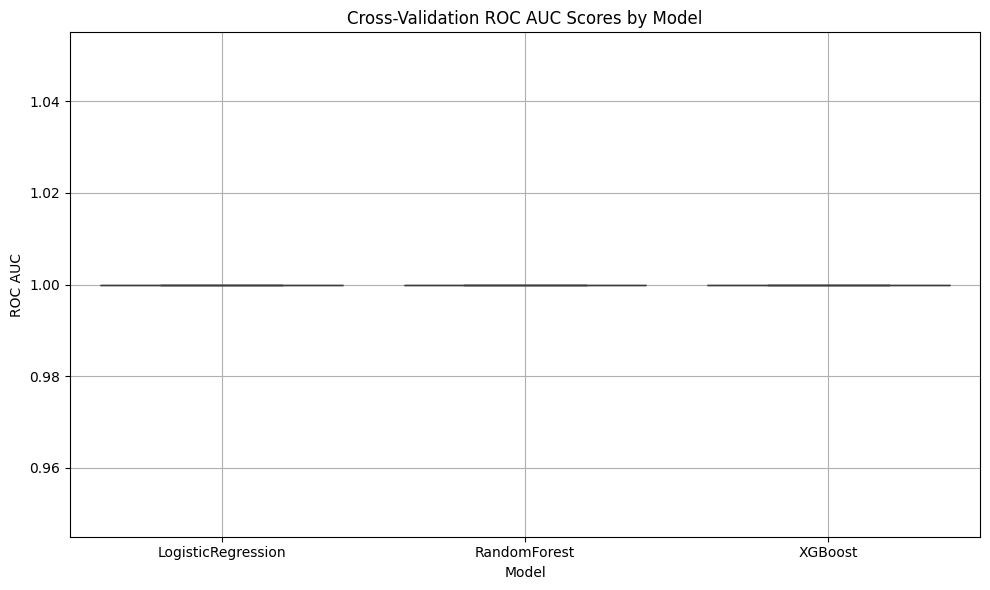


Feature Importance:
                     feature  importance
3              response_rate    0.996463
4         last_response_week    0.003537
0            total_campaigns    0.000000
2                gen_encoded    0.000000
1                cat_encoded    0.000000
5         campaign_diversity    0.000000
6               weeks_active    0.000000
7            early_responses    0.000000
8             late_responses    0.000000
9             response_trend    0.000000
10  time_since_last_response    0.000000

📌 Project Answers:
1. Which Subscribers to Email (First 10 Shown):
[13184, 13183, 13182, 13179, 13178, 13177, 13176, 13174, 13173, 13171]

2. Campaign Distribution for Week 27:
{1: 250, 2: 250, 3: 250, 4: 250, 5: 250, 6: 250, 7: 250, 8: 250, 9: 250, 10: 250}

3. Expected Response Rate: 99.99%

📊 Cross-Validated Model Performance:
             Model ROC AUC Mean ROC AUC Std
LogisticRegression       1.0000      0.0000
      RandomForest       1.0000      0.0000
           XGBoost    

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.pipeline import make_pipeline

# -------------------------------
# 1. Load and clean the data
# -------------------------------
df = pd.read_excel("hist.xlsx")
df.columns = ['week', 'subscriber_id', 'user_category', 'state_id', 'gender', 'campaign_id', 'response']
df = df.fillna(0)

# -------------------------------
# 2. Feature Engineering Function (Time-aware)
# -------------------------------
def engineer_features(df, cutoff_week=None, label_encoders=None):
    """
    If cutoff_week is provided, only use data up to (but not including) that week for features.
    label_encoders: tuple of (le_cat, le_gen) if you want to reuse label encoders.
    Returns: agg, (le_cat, le_gen)
    """
    df_filtered = df.copy()
    if cutoff_week is not None:
        df_filtered = df_filtered[df_filtered['week'] < cutoff_week]

    # If no data after filtering, return empty DataFrame with expected columns
    if len(df_filtered) == 0:
        return pd.DataFrame(), None

    agg = df_filtered.groupby('subscriber_id').agg(
        total_campaigns=('campaign_id', 'count'),
        total_responses=('response', 'sum'),
        last_category=('user_category', 'last'),
        last_state=('state_id', 'last'),
        last_gender=('gender', 'last'),
        first_week=('week', 'min'),
        last_week=('week', 'max')
    ).reset_index()

    # Use or fit label encoders
    if label_encoders is None:
        le_cat = LabelEncoder()
        le_gen = LabelEncoder()
        agg['cat_encoded'] = le_cat.fit_transform(agg['last_category'].astype(str))
        agg['gen_encoded'] = le_gen.fit_transform(agg['last_gender'].astype(str))
    else:
        le_cat, le_gen = label_encoders
        # Handle new categories that might not have been in the training data
        agg['last_category'] = agg['last_category'].astype(str)
        agg['last_gender'] = agg['last_gender'].astype(str)

        # For any new categories, assign a default value
        agg['cat_encoded'] = agg['last_category'].apply(
            lambda x: le_cat.transform([x])[0] if x in le_cat.classes_ else -1
        )
        agg['gen_encoded'] = agg['last_gender'].apply(
            lambda x: le_gen.transform([x])[0] if x in le_gen.classes_ else -1
        )

    agg['response_rate'] = agg['total_responses'] / agg['total_campaigns']
    # Add the responded column directly here to avoid KeyError later
    agg['responded'] = (agg['total_responses'] > 0).astype(int)

    last_response_week = df_filtered[df_filtered['response'] == 1].groupby('subscriber_id')['week'].max().reset_index()
    last_response_week.columns = ['subscriber_id', 'last_response_week']
    agg = agg.merge(last_response_week, on='subscriber_id', how='left')
    agg['last_response_week'] = agg['last_response_week'].fillna(0)
    agg['time_since_last_response'] = agg['last_week'] - agg['last_response_week']

    campaign_div = df_filtered.groupby('subscriber_id')['campaign_id'].nunique().reset_index()
    campaign_div.columns = ['subscriber_id', 'campaign_diversity']
    agg = agg.merge(campaign_div, on='subscriber_id', how='left')

    agg['weeks_active'] = agg['last_week'] - agg['first_week'] + 1

    mid_week = min(13, agg['last_week'].max() / 2)  # Dynamically determine early/late split
    early = df_filtered[df_filtered['week'] <= mid_week].groupby('subscriber_id')['response'].sum().reset_index(name='early_responses')
    late = df_filtered[df_filtered['week'] > mid_week].groupby('subscriber_id')['response'].sum().reset_index(name='late_responses')

    agg = agg.merge(early, on='subscriber_id', how='left').merge(late, on='subscriber_id', how='left')
    agg[['early_responses', 'late_responses']] = agg[['early_responses', 'late_responses']].fillna(0)
    agg['response_trend'] = agg['late_responses'] - agg['early_responses']

    return agg, (le_cat, le_gen) if label_encoders is None else label_encoders

# -------------------------------
# 3. Model Training (CV Evaluation, WITHOUT LEAKAGE)
# -------------------------------
# For training, use only data up to week 26 (i.e., weeks 1-25)
train_agg, encoders = engineer_features(df, cutoff_week=26)

# Make sure responded column exists
if 'responded' not in train_agg.columns:
    print("Warning: 'responded' column not found. Creating from total_responses.")
    train_agg['responded'] = (train_agg['total_responses'] > 0).astype(int)

features = [
    'total_campaigns', 'cat_encoded', 'gen_encoded',
    'response_rate', 'last_response_week', 'campaign_diversity',
    'weeks_active', 'early_responses', 'late_responses', 'response_trend',
    'time_since_last_response'
]

# Make sure all features exist
for feature in features:
    if feature not in train_agg.columns:
        print(f"Warning: Feature '{feature}' not found. Removing from feature list.")
        features.remove(feature)

X = train_agg[features]
y = train_agg['responded']

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

cv_results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    print(f"Cross-validating {name}...")
    scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
    cv_results[name] = scores

# -------------------------------
# 4. Visualize Cross-Validation Results
# -------------------------------
cv_df = pd.DataFrame(cv_results)
plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_df)
plt.title("Cross-Validation ROC AUC Scores by Model")
plt.ylabel("ROC AUC")
plt.xlabel("Model")
plt.grid(True)
plt.tight_layout()
plt.savefig('cv_results.png')  # Save the plot in case display doesn't work
plt.show()

# -------------------------------
# 5. Train Final Model (XGBoost) and Predict Probabilities for Week 27
# -------------------------------
# Use all data up to week 26 to predict for week 27
full_agg, _ = engineer_features(df, cutoff_week=27, label_encoders=encoders)
X_full = full_agg[features]
y_full = full_agg['responded']

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_full, y_full)
full_agg['predicted_proba'] = xgb_model.predict_proba(X_full)[:, 1]

# Print feature importance
print("\nFeature Importance:")
importance = pd.DataFrame({
    'feature': features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print(importance)

# -------------------------------
# 6. Targeting Strategy for Week 27
# -------------------------------
full_agg_sorted = full_agg.sort_values(by='predicted_proba', ascending=False)
top_25 = full_agg_sorted.head(int(0.25 * len(full_agg_sorted))).copy()
top_25['assigned_campaign'] = [(i % 10) + 1 for i in range(len(top_25))]

# Project Questions Answered
question_1 = top_25['subscriber_id'].tolist()
question_2 = top_25.groupby('assigned_campaign').size().to_dict()
expected_response_rate = top_25['predicted_proba'].mean()
question_3 = f"{expected_response_rate:.2%}"

# -------------------------------
# 7. Print Project Answers
# -------------------------------
print("\n\U0001F4CC Project Answers:")
print("1. Which Subscribers to Email (First 10 Shown):")
print(question_1[:10])
print("\n2. Campaign Distribution for Week 27:")
print(question_2)
print(f"\n3. Expected Response Rate: {question_3}")

# -------------------------------
# 8. Print CV Performance Summary
# -------------------------------
cv_summary = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'ROC AUC Mean': [f"{np.mean(scores):.4f}" for scores in cv_results.values()],
    'ROC AUC Std': [f"{np.std(scores):.4f}" for scores in cv_results.values()]
})
print("\n\U0001F4CA Cross-Validated Model Performance:")
print(cv_summary.to_string(index=False))

# -------------------------------
# 9. Holdout Week 26 Validation (NO LEAKAGE)
# -------------------------------
try:
    print("\n--- Running holdout validation ---")
    # Features up to week 25 for training
    df_train = df[df['week'] < 26]
    agg_train, train_encoders = engineer_features(df_train)

    features_holdout = [f for f in features if f in agg_train.columns]
    X_train_holdout = agg_train[features_holdout]
    y_train_holdout = agg_train['responded']

    # Now get the actual responses in week 26 (target)
    df_test = df[df['week'] == 26]

    if len(df_test) > 0:
        print(f"Testing on {len(df_test)} week 26 entries")

        # Get subscribers who were part of week 26
        week26_subscribers = df_test['subscriber_id'].unique()
        print(f"Found {len(week26_subscribers)} unique subscribers in week 26")

        # Get all subscribers in training + their features
        train_subscribers = set(agg_train['subscriber_id'])
        print(f"Found {len(train_subscribers)} subscribers in training set")

        # Calculate responses in week 26
        week26_response = df_test.groupby('subscriber_id')['response'].max().reset_index()
        week26_response.columns = ['subscriber_id', 'responded_week26']

        # Filter for subscribers that exist in both training and week 26
        common_subscribers = set(week26_subscribers) & train_subscribers
        print(f"Found {len(common_subscribers)} subscribers in both training and week 26")

        if len(common_subscribers) > 0:
            agg_test = agg_train[agg_train['subscriber_id'].isin(common_subscribers)].copy()
            agg_test = agg_test.merge(week26_response, on='subscriber_id', how='left')

            X_test_holdout = agg_test[features_holdout]
            y_test_holdout = agg_test['responded_week26']

            model_holdout = XGBClassifier(eval_metric='logloss', random_state=42)
            model_holdout.fit(X_train_holdout, y_train_holdout)
            y_pred_holdout = model_holdout.predict(X_test_holdout)
            y_proba_holdout = model_holdout.predict_proba(X_test_holdout)[:, 1]

            print("\n\U0001F4CA Evaluation on Simulated Week 27 (actual Week 26):")
            print(classification_report(y_test_holdout, y_pred_holdout))
            print("ROC AUC Score:", round(roc_auc_score(y_test_holdout, y_proba_holdout), 4))
        else:
            print("No common subscribers found between training and week 26 for validation.")
    else:
        print("No data found for week 26 validation.")

except Exception as e:
    print(f"Error in holdout validation: {e}")
    import traceback
    traceback.print_exc()